In [1]:
import os
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/blue_bikes_trip_data/201701-hubway-tripdata.csv', index_col=1, parse_dates=True)

path = './data/blue_bikes_trip_data/'
for file in sorted(os.listdir(path))[1:]:
    df_new = pd.read_csv(path+file, index_col=1, parse_dates=True)
    frames = [df,df_new]
    df = pd.concat(frames)


In [3]:
counts = df.groupby([pd.Grouper(freq='D'),'usertype']).count().reset_index().iloc[:, : 3]
counts.columns = ['time', 'user', 'rides']
counts = pd.pivot_table(counts,values = 'rides',index = 'time',columns='user').fillna(0)

sum_col = counts["Customer"] + counts["Subscriber"]
counts["total"] = sum_col

daily_data = counts.reset_index()
daily_data=daily_data.drop(['Customer','Subscriber'],axis=1)
daily_data.columns.name = None

In [4]:
if 'time' in daily_data.columns:
    daily_data=daily_data.set_index('time')
    daily_data.index = daily_data.index.date

    daily_data.loc[dt.datetime.strptime('2018-03-13', '%Y-%m-%d').date()] = [0]
    daily_data.loc[dt.datetime.strptime('2019-01-20', '%Y-%m-%d').date()] = [0]
    
daily_data.sort_index(inplace=True)
daily_data.index.rename('date',inplace=True)

In [5]:
from darts import TimeSeries
from darts.models import Prophet, FFT

series1 = TimeSeries.from_dataframe(daily_data.reset_index(), 'date', 'total')

soe_date = '2020-03-11'
daily_data_pre_soe = daily_data.iloc[:daily_data.index.get_loc(dt.datetime.strptime(soe_date, '%Y-%m-%d').date()),:]
series2 = TimeSeries.from_dataframe(daily_data_pre_soe.reset_index(), 'date', 'total')

thru_june = '2020-06-30'
daily_data_thru_june = daily_data.iloc[:daily_data.index.get_loc(dt.datetime.strptime(thru_june, '%Y-%m-%d').date()),:]
series3 = TimeSeries.from_dataframe(daily_data_thru_june.reset_index(), 'date', 'total')

In [6]:
train1, val1 = series1.split_before(pd.Timestamp('20200101'))
train2, val2 = series2.split_before(pd.Timestamp('20200101'))
train3, val3 = series3.split_before(pd.Timestamp('20200601'))

In [40]:
import time
start_time = time.time()

model_FFT1 = FFT()
model_FFT1.fit(train1)
prediction_FFT1 = model_FFT1.predict(len(val1))

model_Prophet1 = Prophet()
model_Prophet1.fit(train1)
prediction_Prophet1 = model_Prophet1.predict(len(val1))

print("--- %s seconds ---" % (time.time() - start_time))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--- 2.9871602058410645 seconds ---


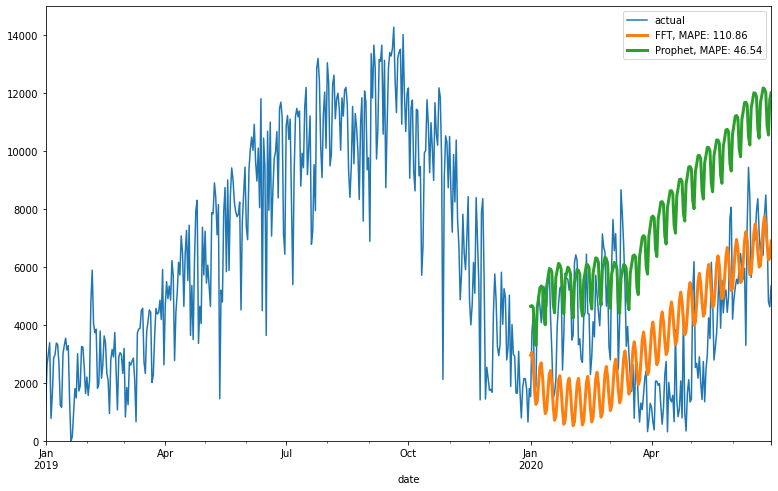

In [37]:
from darts.metrics import mape

plt.figure(figsize=(13, 8))
series1.plot(label='actual')
prediction_FFT1.plot(label='FFT, MAPE: '+str(round(mape(prediction_FFT1, series1),2)),lw=3)
prediction_Prophet1.plot(label='Prophet, MAPE: '+str(round(mape(prediction_Prophet1, series1),2)),lw=3)
plt.axis([dt.datetime.strptime('2019-01-01', '%Y-%m-%d').date(),dt.datetime.strptime('2020-06-30', '%Y-%m-%d').date(),0,15000])
plt.legend()

In [41]:
model_FFT2 = FFT()
model_FFT2.fit(train2)
prediction_FFT2 = model_FFT2.predict(len(val2))

model_Prophet2 = Prophet()
model_Prophet2.fit(train2)
prediction_Prophet2 = model_Prophet2.predict(len(val2))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


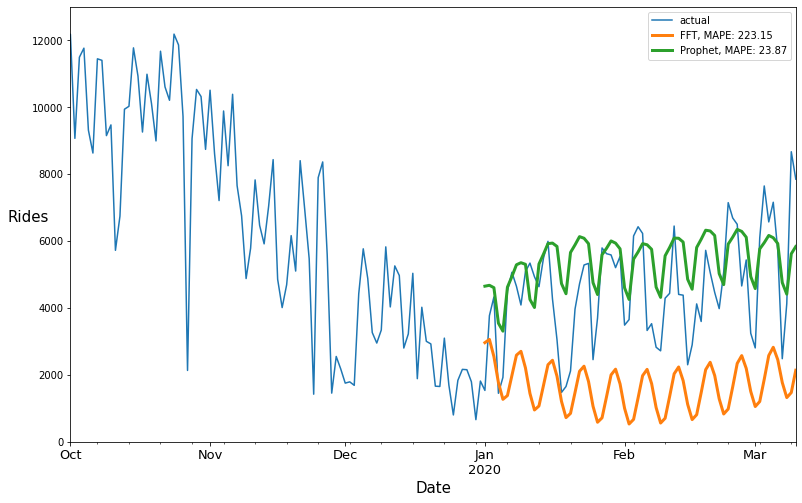

In [28]:
plt.figure(figsize=(13, 8))
series2.plot(label='actual')
prediction_FFT2.plot(label='FFT, MAPE: '+str(round(mape(prediction_FFT2, series2),2)),lw=3)
prediction_Prophet2.plot(label='Prophet, MAPE: '+str(round(mape(prediction_Prophet2, series2),2)),lw=3)
plt.axis([dt.datetime.strptime('2019-10-01', '%Y-%m-%d').date(),dt.datetime.strptime('2020-03-10', '%Y-%m-%d').date(),0,13000])
plt.ylabel('Rides',rotation=0,size=15)
plt.xlabel('Date',rotation=0,size=15)
plt.tick_params(axis='x', which='major', labelsize=13)
plt.legend()
plt.show()

In [30]:
model_FFT3 = FFT()
model_FFT3.fit(train3)
prediction_FFT3 = model_FFT3.predict(len(val3))

model_Prophet3 = Prophet()
model_Prophet3.fit(train3)
prediction_Prophet3 = model_Prophet3.predict(len(val3))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


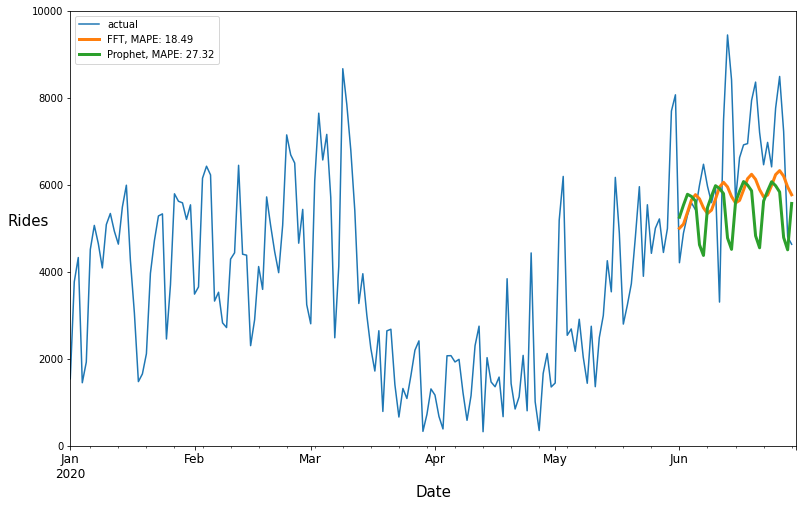

In [33]:
plt.figure(figsize=(13, 8))
series3.plot(label='actual')
prediction_FFT3.plot(label='FFT, MAPE: '+str(round(mape(prediction_FFT3, series3),2)),lw=3)
prediction_Prophet3.plot(label='Prophet, MAPE: '+str(round(mape(prediction_Prophet3, series3),2)),lw=3)
plt.axis([dt.datetime.strptime('2020-01-01', '%Y-%m-%d').date(),dt.datetime.strptime('2020-06-30', '%Y-%m-%d').date(),0,10000])
plt.ylabel('Rides',rotation=0,size=15)
plt.xlabel('Date',rotation=0,size=15)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.legend()
plt.show()

In [13]:
start_fc = '2020-06-01'
end_fc = '2020-06-30'
start_fc_int = daily_data.index.get_loc(dt.datetime.strptime(start_fc, '%Y-%m-%d').date())
end_fc_int = daily_data.index.get_loc(dt.datetime.strptime(end_fc, '%Y-%m-%d').date())
train = daily_data.iloc[:start_fc_int,:]
test = daily_data.iloc[start_fc_int:end_fc_int,:]

In [14]:
from tbats import TBATS, BATS

In [15]:
start_time = time.time()

# Fit the model
estimator = TBATS(seasonal_periods=(7, 365))
model = estimator.fit(train.total)
# Forecast 365 days ahead
y_forecast = model.forecast(steps=test.shape[0])

print("--- %s seconds ---" % (time.time() - start_time))

--- 237.8314881324768 seconds ---


In [43]:
def mean_absolute_percentage_error(y_true, y_pred):
    
    pred_arr = np.array(y_pred)
    perc_errs = []
    for i in range(y_true.shape[0]):
        perc_errs.append((y_true[i] - pred_arr[i]) / y_true[i])
    
    return round(np.mean(np.abs(perc_errs)) * 100 , 2)

In [34]:
forecast = pd.DataFrame(y_forecast, index = test.index)

plt.figure(figsize=(13, 8))
plt.plot(train['total'], label='Train')
plt.plot(test['total'], label='Test')
plt.plot(forecast, label='TBATS, MAPE: '+str(mean_absolute_percentage_error(test.total, forecast)))
plt.axis([dt.datetime.strptime('2020-01-01', '%Y-%m-%d').date(),dt.datetime.strptime(end_fc, '%Y-%m-%d').date(),0,10000])
plt.ylabel('Rides',rotation=0,size=15)
plt.xlabel('Date',rotation=0,size=15)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.legend()
plt.show()

NameError: name 'y_forecast' is not defined

In [61]:
print(mean_absolute_percentage_error(np.full(1000,10),np.random.normal(10, 5, 1000)))

39.93


array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10

In [ ]:
from fbprophet import Prophet

In [ ]:
p_train = train.reset_index()
p_train.columns = ['ds','y']
p_train

In [ ]:
p_test = test.reset_index()
p_test.columns = ['ds','y']
step = 1
p_test.index = pd.RangeIndex(start=daily_data.index.get_loc(dt.datetime.strptime(start_fc, '%Y-%m-%d').date()), stop=daily_data.index.get_loc(dt.datetime.strptime(end_fc, '%Y-%m-%d').date()), step=step)
p_test

In [ ]:
m1 = Prophet()
m1.fit(p_train)

In [ ]:
future1 = m1.make_future_dataframe(periods=test.shape[0])
forecast1 = m1.predict(future1)
forecast1

In [ ]:
m1.plot(forecast1);

In [ ]:
p_train_plot = p_train.set_index(p_train.ds)
p_test_plot = p_test.set_index(p_test.ds)
p_forecast_plot = forecast1.set_index(forecast1.ds)

plt.figure(figsize=(16, 8))

plt.plot(p_train_plot['y'], label='Train')
plt.plot(p_forecast_plot['yhat'], label='forecast')
plt.plot(p_test_plot['y'], label='Test')
plt.legend(loc='best')
plt.axis([dt.datetime.strptime('2020-01-01', '%Y-%m-%d').date(),dt.datetime.strptime(end_fc, '%Y-%m-%d').date(),0,12000])

plt.show()

In [ ]:
print('MAE: ',mean_absolute_error(p_test.y, p_forecast_plot.yhat.loc[start_fc : end_fc]))

In [ ]:
def create_features(df, label=None):
    print(df)
    df.reset_index(inplace=True)
    df.columns = ['date', 'total']
    print(df)
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['day_of_week'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df["season"] = df.month.map({3 : 'Spring', 4 : 'Spring', 5 : 'Spring', 6 : 'Summer', 7 : 'Summer', 8 : 'Summer', 9 : 'Fall', 10 : 'Fall', 11 : 'Fall', 12 : 'Winter', 1  : 'Winter', 2 : 'Winter' })
    df['year'] = df['date'].dt.year
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.weekofyear
    
    X = df[['day_of_week','quarter','month','year',
           'day_of_year','day_of_month','week_of_year']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
X_train, y_train = create_features(train, label='total')
X_test, y_test = create_features(test, label='total')

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train